<a href="https://colab.research.google.com/github/redwineyards/autoencoders/blob/main/simple-autoencoders/conv_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
seed=42
torch.manual_seed(seed)
if device=='cuda': torch.cuda.manual_seed_all(seed)

root="/content/data"
trans=transforms.Compose([transforms.ToTensor()])
training_set=torchvision.datasets.MNIST(root=root,train=True,transform=trans,download=True)
test_set=torchvision.datasets.MNIST(root=root, train=False,transform=trans, download=True)

num_epochs=15
learning_rate=1e-3
batch_size=128
train_loader=torch.utils.data.DataLoader(training_set,batch_size=batch_size,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=False)

True


In [2]:
class ConvAE(nn.Module):
  def __init__(self):
    super(ConvAE,self).__init__()
    self.encoder=nn.Sequential(
        nn.Conv2d(1,8,5,stride=1),
        nn.ReLU(),
        nn.Conv2d(8,16,3,stride=2),
        nn.ReLU(),
        nn.Conv2d(16,32,1,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
    )
    self.decoder=nn.Sequential(
        nn.ConvTranspose2d(32,16,3, stride=2),
        nn.ReLU(),
        nn.ConvTranspose2d(16,8,5, stride=2),
        nn.ReLU(),
        nn.ConvTranspose2d(8,1,4, stride=1),
        nn.Sigmoid()
    )
  def encode(self,input):
    features=self.encoder(input.float())
    return features
  def decode(self,features):
    reconstruction=self.decoder(features.float())
    return reconstruction
  def forward(self,x):
    output=self.encode(x)
    output=self.decode(output)
    return output

In [3]:
def train(model,train_loader,num_epochs,learning_rate):
  losses=[]
  optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
  lossfn=torch.nn.BCELoss()
  model.train()
  for epoch in range(num_epochs):
    for i,(images,_) in enumerate(train_loader):
      images=images.to(device)
      output=model.forward(images)
      loss=lossfn(output,images.float())
      losses.append(loss)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      if (i + 1) % 200 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs,loss.item()))
  return losses

In [4]:
def evaluate(model,test_loader):
  lossfn=torch.nn.BCELoss()
  model.eval()
  with torch.no_grad():
    total=0
    for i,(images,_) in enumerate(test_loader):
      images=images.to(device)
      output=model.forward(images)
      total+=lossfn(output,images.float())
    
    loss=total/len(test_loader)
    print("model test loss on MNIST test set:", loss.item())

In [5]:
model=ConvAE().to(device)
losses=train(model,train_loader,num_epochs,learning_rate)

Epoch [1/15], Loss: 0.1184
Epoch [1/15], Loss: 0.0945
Epoch [2/15], Loss: 0.0870
Epoch [2/15], Loss: 0.0801
Epoch [3/15], Loss: 0.0803
Epoch [3/15], Loss: 0.0775
Epoch [4/15], Loss: 0.0751
Epoch [4/15], Loss: 0.0735
Epoch [5/15], Loss: 0.0746
Epoch [5/15], Loss: 0.0742
Epoch [6/15], Loss: 0.0741
Epoch [6/15], Loss: 0.0722
Epoch [7/15], Loss: 0.0714
Epoch [7/15], Loss: 0.0716
Epoch [8/15], Loss: 0.0708
Epoch [8/15], Loss: 0.0708
Epoch [9/15], Loss: 0.0694
Epoch [9/15], Loss: 0.0718
Epoch [10/15], Loss: 0.0709
Epoch [10/15], Loss: 0.0693
Epoch [11/15], Loss: 0.0702
Epoch [11/15], Loss: 0.0688
Epoch [12/15], Loss: 0.0699
Epoch [12/15], Loss: 0.0662
Epoch [13/15], Loss: 0.0702
Epoch [13/15], Loss: 0.0690
Epoch [14/15], Loss: 0.0701
Epoch [14/15], Loss: 0.0712
Epoch [15/15], Loss: 0.0686
Epoch [15/15], Loss: 0.0670


In [6]:
evaluate(model,test_loader)

model test loss on MNIST test set: 0.06910720467567444


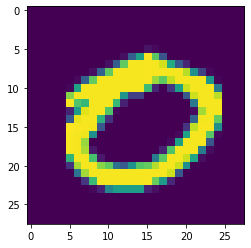

In [24]:
tens1=training_set[114][0].reshape(-1,1,28,28)
test1=np.squeeze(tens1.numpy())
plt.imshow(test1)

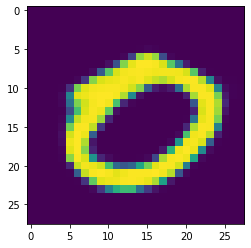

In [25]:
with torch.no_grad():
  tens1_reconstr=model.forward(tens1.to(device))
  test1_reconstr=np.squeeze(tens1_reconstr.cpu().numpy())
  plt.imshow(test1_reconstr)